# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1rGCu5g-Bo1BkEJxSGoyYdJdFSZAyvIdT?usp=sharing 

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [3]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [4]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

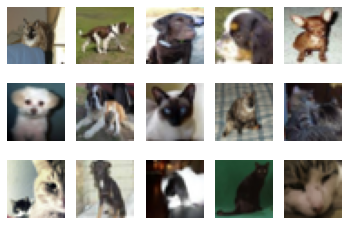

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print(f"training examples: {len(train_loader)}")
print(f"validation examples: {len(val_loader)}")
print(f"test examples: {len(test_loader)}")

training examples: 8000
validation examples: 2000
test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
''' 
The validation data is used to check how well our model has actually been trained. 
Without it, the model could end up overfitted to the training data.
'''

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
def num_params(network):
  return sum(param.numel() for param in network.parameters())

print(f"small_net params: {num_params(small_net)}")
print(f"large_net params: {num_params(large_net)}")

small_net params: 386
large_net params: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [12]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
'''
Default values:
- batch_size = 64
- learning_rate = 0.01
- num_epoches = 30
'''

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
'''
- After every single epoch (5 times), the current state of the model is saved. 
  `torch.save(net.state_dict(), model_path)` serializes and saves the model parameters.

- After all 5 epochs are complete, the following results are saved.
  * {path}_train_err.csv: Training error
  * {path}_train_loss.csv: Training loss
  * {path}_val_err.csv: Validation error
  * {path}_val_loss.csv: Validation loss
'''

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [30]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.41475, Train loss: 0.6710798382759094 |Validation err: 0.3725, Validation loss: 0.6496782377362251
Epoch 2: Train err: 0.355875, Train loss: 0.6380062270164489 |Validation err: 0.37, Validation loss: 0.652825528755784
Epoch 3: Train err: 0.336875, Train loss: 0.6196097664833069 |Validation err: 0.3455, Validation loss: 0.6218187250196934
Epoch 4: Train err: 0.326, Train loss: 0.6044293246269226 |Validation err: 0.3585, Validation loss: 0.6307820025831461
Epoch 5: Train err: 0.31225, Train loss: 0.5961454961299896 |Validation err: 0.338, Validation loss: 0.6211910247802734
Epoch 6: Train err: 0.31075, Train loss: 0.5883837196826934 |Validation err: 0.3345, Validation loss: 0.6192649994045496
Epoch 7: Train err: 0.305875, Train loss: 0.5855855982303619 |Validation err: 0.328, Validation loss: 0.612101336941123
Epoch 8: Train err: 0.299, Train loss: 0.5790406625270843 |Validation err: 0.3255,

In [ ]:
'''
-- TIME
small_net: 98.14s
large_net: 108.74s

-- ANALYSIS
The time difference is due to large_net having over 25x the parameters of small_net.
'''

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [15]:
def plot(path, batch_size=64, learning_rate=0.01, epoch=29):
  model_path = get_model_name(path, batch_size, learning_rate, epoch)
  plot_training_curve(model_path)

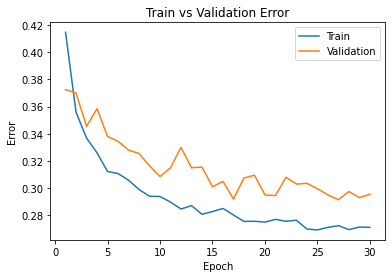

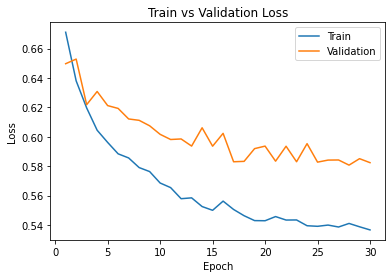

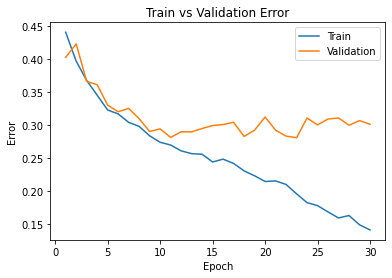

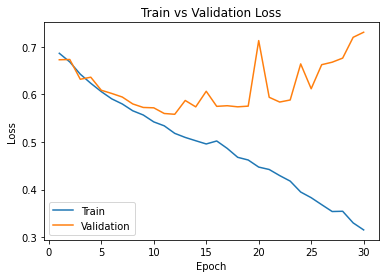

In [16]:
plot("small")
plot("large")

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
'''
-- SMALL NET:
All decreasing till they flatten off.
- Training error: plateaus around ~0.28
- Validation error: plateaus around ~0.3 
- Training loss: plateaus ~0.54
- Validation loss: plateaus ~0.58

-- Large Net:
Shows signs of overfitting as the validation loss starts rapidly increasing around 15 epochs, 
while the training loss keeps impoving (overfitted to training data). Another sign is the 
validation error also hits a plataeu while the training error keeps decreasing.

By epoch 30:
- Training error: ~0.15
- Validation error: ~0.3 
- Training loss: ~0.3
- Validation loss: ~0.75
'''

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205230712891 |Validation err: 0.491, Validation loss: 0.6929903700947762
Epoch 2: Train err: 0.50225, Train loss: 0.6930275983810424 |Validation err: 0.491, Validation loss: 0.6924116965383291
Epoch 3: Train err: 0.48725, Train loss: 0.6922533841133117 |Validation err: 0.4765, Validation loss: 0.6920256949961185
Epoch 4: Train err: 0.44875, Train loss: 0.6916870517730713 |Validation err: 0.4515, Validation loss: 0.6913812514394522
Epoch 5: Train err: 0.44225, Train loss: 0.691071638584137 |Validation err: 0.4415, Validation loss: 0.6910937111824751
Epoch 6: Train err: 0.44025, Train loss: 0.6903762383460998 |Validation err: 0.437, Validation loss: 0.6905076932162046
Epoch 7: Train err: 0.437875, Train loss: 0.6895537686347961 |Validation err: 0.434, Validation loss: 0.6896947734057903
Epoch 8: Train err: 0.43875, Train loss: 0.6884713101387024 |Validation err: 0.43

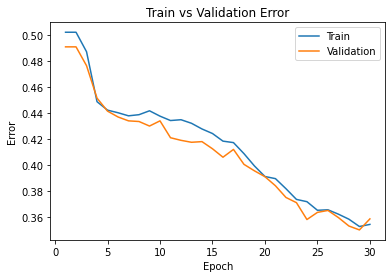

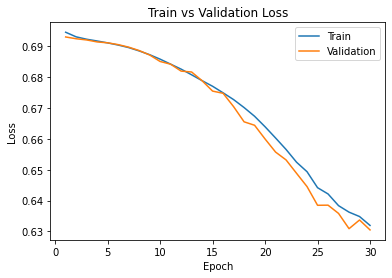

In [17]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
plot("large", learning_rate=0.001)

In [ ]:
'''
-- TIME:
Default:                108.74s
Learning Rate = 0.001:  110.53s

-- ANALYSIS:
The model takes about the same time (only 1.79s longer).

Lowering learning rate resulted in validation error no longer increasing, 
thus avoided overfitting. 

However, the training error is double that of the default and the 
validation error ends at ~0.36 which is higher than the default, and
starting to show signs of undefitting as the model is adapting very slowly and thus going to take more ephochs 
to achieve the same results as the default.
'''

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3955, Train loss: 0.6611037940979004 |Validation err: 0.3665, Validation loss: 0.6420795805752277
Epoch 2: Train err: 0.35825, Train loss: 0.6269370760917664 |Validation err: 0.361, Validation loss: 0.6158483941107988
Epoch 3: Train err: 0.341625, Train loss: 0.6099651448726654 |Validation err: 0.347, Validation loss: 0.6308596134185791
Epoch 4: Train err: 0.33175, Train loss: 0.6029158439636231 |Validation err: 0.34, Validation loss: 0.6324907867237926
Epoch 5: Train err: 0.314875, Train loss: 0.5777306914329529 |Validation err: 0.3415, Validation loss: 0.5985537674278021
Epoch 6: Train err: 0.304625, Train loss: 0.569288028717041 |Validation err: 0.339, Validation loss: 0.6097556836903095
Epoch 7: Train err: 0.290375, Train loss: 0.5603433194160461 |Validation err: 0.3135, Validation loss: 0.6133970078080893
Epoch 8: Train err: 0.286875, Train loss: 0.5542317173480987 |Validation err: 0.

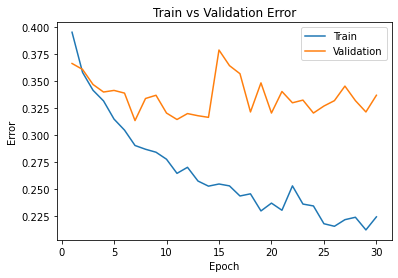

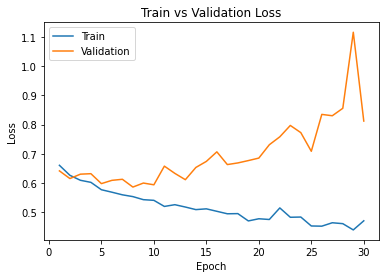

In [18]:
train_net(large_net, learning_rate=0.1)
plot("large", learning_rate=0.1)

In [ ]:
'''
-- TIME:
Default:              108.74s
Learning Rate = 0.1:  108.64s

-- ANALYSIS:
The model takes about the same time (only 0.1s shorter).

Increasing the learning rate resulted in overfitting the data. Around 3 ephochs
the validation loss starts to dramatically increase while the training loss decreases, 
showing that at this rate the model is adapting too quickly.
'''

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.20325, Train loss: 0.4219541884958744 |Validation err: 0.332, Validation loss: 0.8246169239282608
Epoch 2: Train err: 0.180875, Train loss: 0.38694511353969574 |Validation err: 0.329, Validation loss: 0.8529137521982193
Epoch 3: Train err: 0.168875, Train loss: 0.36221651174128056 |Validation err: 0.3235, Validation loss: 0.8726461827754974
Epoch 4: Train err: 0.159625, Train loss: 0.34615342132747173 |Validation err: 0.321, Validation loss: 0.8936197757720947
Epoch 5: Train err: 0.155375, Train loss: 0.3355055619031191 |Validation err: 0.3225, Validation loss: 0.9145962744951248
Epoch 6: Train err: 0.151125, Train loss: 0.32531799748539925 |Validation err: 0.3185, Validation loss: 0.9374296963214874
Epoch 7: Train err: 0.1465, Train loss: 0.31778930500149727 |Validation err: 0.3175, Validation loss: 0.9506326466798782
Epoch 8: Train err: 0.1435, Train loss: 0.31213077902793884 |Validation

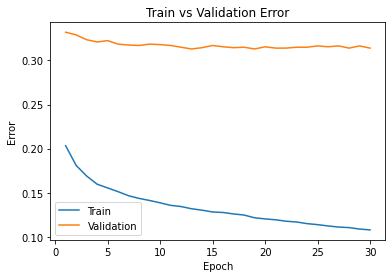

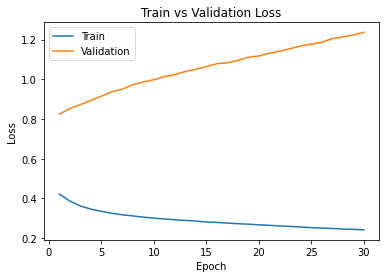

In [19]:
train_net(large_net, batch_size=512)
plot("large", batch_size=512)

In [ ]:
'''
-- TIME:
Default:           108.74s
Batch size = 512:  94.22s

-- ANALYSIS:
The model takes less time to train as less iterations are needed.

Increasing the batch size resulted in overfitting. The validation loss is entirely
increasing while the training loss is decreasing. The errors are both lower than
the default though.
'''

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.135875, Train loss: 0.29505080155283214 |Validation err: 0.3205, Validation loss: 1.1124554742574693
Epoch 2: Train err: 0.125, Train loss: 0.27878469954431057 |Validation err: 0.324, Validation loss: 1.1523246252536774
Epoch 3: Train err: 0.113375, Train loss: 0.24907811103761196 |Validation err: 0.32, Validation loss: 1.2918848145008086
Epoch 4: Train err: 0.109, Train loss: 0.23980945750698449 |Validation err: 0.335, Validation loss: 1.472963587284088
Epoch 5: Train err: 0.101125, Train loss: 0.22566715380176902 |Validation err: 0.333, Validation loss: 1.4308728227615357
Epoch 6: Train err: 0.096875, Train loss: 0.21881181903928518 |Validation err: 0.322, Validation loss: 1.6147809895277023
Epoch 7: Train err: 0.08575, Train loss: 0.20000880510546268 |Validation err: 0.3225, Validation loss: 1.712071604013443
Epoch 8: Train err: 0.08975, Train loss: 0.20889742119424046 |Validation err: 

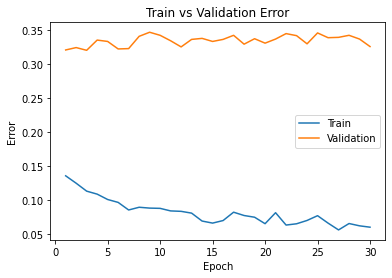

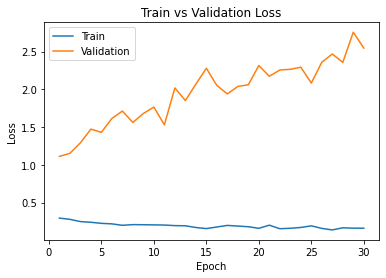

In [20]:
train_net(large_net, batch_size=16)
plot("large", batch_size=16)

In [ ]:
'''
-- TIME:
Default:           108.74s
Batch size = 16:   171.00s

-- ANALYSIS:
The model takes a lot longer to train as there are more iterations needed.

Decreasing the batch size resulted in aggressive overfitting. Validation loss increases 
right away while the training loss stays quite constant with slight decrease.

Both the training and validation error are lower than the default though.
'''

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

`Answer`

**Oberservations** 

parameter | value | general conclusion
--|--|--|
learning rate | 0.001 | too low, underfit
learning rate | 0.1 | too high, overfit
batch size | 512 | too high, underfit
batch size | 16 | too low, overfit

Based on my oberservations, I'm choosing the half way points between what I've tested to search for a balance that's not over or under fit. I'm leaving the epochs as the default as an anchoring paramter.


Hyperparameters: 
* `Learning rate`: 0.005
* `Batch size`: 256
* `Epoch`: 30

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6945412307977676 |Validation err: 0.509, Validation loss: 0.6948362439870834
Epoch 2: Train err: 0.49775, Train loss: 0.6930719316005707 |Validation err: 0.507, Validation loss: 0.6930415853857994
Epoch 3: Train err: 0.49625, Train loss: 0.6922001242637634 |Validation err: 0.505, Validation loss: 0.6922089457511902
Epoch 4: Train err: 0.485875, Train loss: 0.6913880128413439 |Validation err: 0.4635, Validation loss: 0.6913147121667862
Epoch 5: Train err: 0.4505, Train loss: 0.6903488393872976 |Validation err: 0.427, Validation loss: 0.6899490356445312
Epoch 6: Train err: 0.4435, Train loss: 0.6894257981330156 |Validation err: 0.43, Validation loss: 0.688478484749794
Epoch 7: Train err: 0.4405, Train loss: 0.6879421547055244 |Validation err: 0.4385, Validation loss: 0.6864868178963661
Epoch 8: Train err: 0.441375, Train loss: 0.6862346865236759 |Validation err: 0.435, V

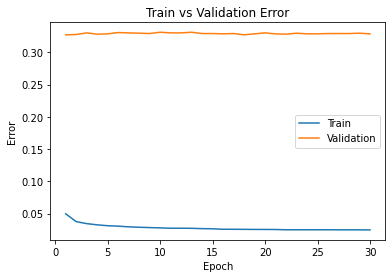

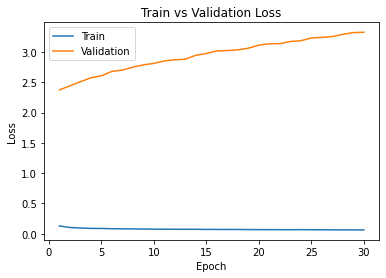

In [44]:
large_net = LargeNet()
train_net(large_net, batch_size=256, learning_rate=0.005, num_epochs=29)
plot("large", batch_size=256, learning_rate=0.005, epoch=29)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
'''
Learning rate: 
  Doubling value to be back to the default as the model is stagnating and not making 
  significant changes in progress within 30 epochs.
Batch size:
  Cutting the batch size in half again as it's overfit (validation loss significantly 
  increasing while training loss more or less constant)

New hyperparameters:
* Learning rate: 0.01
* Batch size: 128 

Ammendment: 
After testing with paramters above, I lowered epochs from 29 to 21 for the final test in part 5 
as the most optimal validaiton loss was achieved at this point.
'''

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [43]:
large_net = LargeNet()
train_net(large_net, batch_size=128, learning_rate=0.01, num_epochs=21)
plot("large", batch_size=128, learning_rate=0.01, epoch=21)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477, Train loss: 0.6927168492286925 |Validation err: 0.4015, Validation loss: 0.6891417726874352
Epoch 2: Train err: 0.4235, Train loss: 0.6830178470838637 |Validation err: 0.413, Validation loss: 0.6734967269003391
Epoch 3: Train err: 0.386875, Train loss: 0.6590630203958542 |Validation err: 0.3585, Validation loss: 0.6357203535735607
Epoch 4: Train err: 0.356, Train loss: 0.6301081909073724 |Validation err: 0.352, Validation loss: 0.6269339881837368
Epoch 5: Train err: 0.328375, Train loss: 0.6093514041295127 |Validation err: 0.337, Validation loss: 0.614628329873085
Epoch 6: Train err: 0.318375, Train loss: 0.5931001660369691 |Validation err: 0.3365, Validation loss: 0.6226309686899185
Epoch 7: Train err: 0.302875, Train loss: 0.5806879070070055 |Validation err: 0.312, Validation loss: 0.5889335535466671
Epoch 8: Train err: 0.295875, Train loss: 0.5707398686144087 |Validation err: 0.306

OSError: ignored

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [14]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.01, epoch=20)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
'''
These are the hyperparameters in my testing in the previous part that got me in the best results.
In the tesing above, I had used a constant epoch number as a control to see the effects of the 
other parameters. Now, I've lowered it to 20 as that's around the point I see the most optimal
error and loss.
'''

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [33]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

criterion = nn.BCEWithLogitsLoss()
print(f"Validation (error, loss): {evaluate(net, val_loader, criterion)}")
print(f"Testing classification (error, loss): {evaluate(net, test_loader, criterion)}")

Files already downloaded and verified
Files already downloaded and verified
Validation error: (0.281, 0.5614161435514688)
Testing classification error: (0.2875, 0.5539729241281748)


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
'''
In my case, they're actually about the same. I'd expect the test error to be higher
because I'm training the model using the training data and using the validaiton data
to tune the hyperparameters. The test data is something my model hasn't seen yet, 
thus resembling it's real-world performance, which would be lower than that achieved
in ideal conditions.
'''

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
'''
If I test the model using the test data, it essentially gets to cheat and memorize the
answers, developing a bias. Thus, the test data would be reflective of the models 
true performance. It's important to use the test data as little as possible to 
get the true measure of how the model would perform with data it hasn't encountered.
'''

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [39]:
torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3) # img size 32x32, rgb 3 channels
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1) # flatten
        return activation2

pigeon = Pigeon()
train_net(pigeon, batch_size=128, learning_rate=0.01, num_epochs=20)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)
criterion = nn.BCEWithLogitsLoss()
print(f"Validation (error, loss): {evaluate(pigeon, val_loader, criterion)}")
print(f"Testing classification (error, loss): {evaluate(pigeon, test_loader, criterion)}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4095, Train loss: 0.6664598991000463 |Validation err: 0.391, Validation loss: 0.6520312875509262
Epoch 2: Train err: 0.36475, Train loss: 0.6363911363813612 |Validation err: 0.396, Validation loss: 0.6572540700435638
Epoch 3: Train err: 0.35275, Train loss: 0.626259670371101 |Validation err: 0.383, Validation loss: 0.6458991803228855
Epoch 4: Train err: 0.338625, Train loss: 0.6112620641314794 |Validation err: 0.409, Validation loss: 0.6707274205982685
Epoch 5: Train err: 0.32775, Train loss: 0.598338508416736 |Validation err: 0.381, Validation loss: 0.6461708918213844
Epoch 6: Train err: 0.312375, Train loss: 0.5867426698170011 |Validation err: 0.3795, Validation loss: 0.6482044942677021
Epoch 7: Train err: 0.299, Train loss: 0.5686618728297097 |Validation err: 0.382, Validation loss: 0.6693910323083401
Epoch 8: Train err: 0.285, Train loss: 0.5588128372790322 |Validation err: 0.38, Valid

In [ ]:
'''
The ANN model perfoms significantly worse than the CNN model.

CNN:
Validation error: (0.281, 0.5614161435514688)
Testing classification error: (0.2875, 0.5539729241281748)

ANN:
Validation (error, loss): (0.382, 1.0336921028792858)
Testing classification (error, loss): (0.3755, 1.0339138358831406)
'''